In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Install PuLP library for optimization
!pip install pulp geopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 103.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Load your dataset (adjust the path if you upload to Google Drive)
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'  # Update this path if necessary
#data = pd.read_csv(file_path)
data = pd.read_csv(file_path, encoding='latin-1')  # Pass encoding as an argument to pd.read_csv

# Display the first few rows to understand the structure
data.head()


Type  Days for shipping (real)  Days for shipment (scheduled)  \
0   PAYMENT                         5                              4   
1   PAYMENT                         5                              4   
2  TRANSFER                         6                              2   
3     DEBIT                         2                              4   
4     DEBIT                         2                              4   

    Delivery Status  Product Sales  Late_delivery_risk     Category Name  \
0     Late delivery     314.640015                   1  Kids' Golf Clubs   
1     Late delivery     311.359985                   1   Women's Apparel   
2     Late delivery     309.720001                   1   Women's Apparel   
3  Advance shipping     304.809998                   0            Cleats   
4  Advance shipping     298.250000                   0            Cleats   

  New Category Name  Customer Id     Customer City  ...  \
0       Kids & Toys        20755  South Ozone Park  ...   
1   Women's Apparel        19492  South Ozone Park  ...   
2   Women's Apparel        19491            Caguas  ...   
3  Sports Equipment        19490            Caguas  ...   
4  Sports Equipment        19489            Caguas  ...   

  Order Profit Per Order     Order Region                      Order State  \
0            -598.390015  Southern Europe                         Cataluña   
1             -57.529999  Southern Europe                         Cataluña   
2              42.000000   Western Europe                          Amberes   
3              89.629997   Western Europe  Alsacia-Champaña-Ardenas-Lorena   
4              29.700001   Western Europe  Alsacia-Champaña-Ardenas-Lorena   

      Order Status  Product Card Id  Product Category Id  \
0  PENDING_PAYMENT              303                   38   
1  PENDING_PAYMENT              502                   24   
2          PENDING              502                   24   
3          ON_HOLD              365                   17   
4          ON_HOLD              365                   17   

                           Product Name  Product Price  \
0     Garmin Forerunner 910XT GPS Watch     399.989990   
1  Nike Men's Dri-FIT Victory Golf Polo      50.000000   
2  Nike Men's Dri-FIT Victory Golf Polo      50.000000   
3      Perfect Fitness Perfect Rip Deck      59.990002   
4      Perfect Fitness Perfect Rip Deck      59.990002   

   shipping date (DateOrders)   Shipping Mode  
0              9/30/2017 9:06  Standard Class  
1              9/30/2017 9:06  Standard Class  
2              9/30/2017 8:56    Second Class  
3              9/30/2017 7:53  Standard Class  
4              9/30/2017 7:53  Standard Class  

[5 rows x 41 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix, save_npz
from geopy.distance import geodesic
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Load your dataset (adjust the path if you upload to Google Drive)
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'  # Update this path if necessary
data = pd.read_csv(file_path, encoding='latin-1')  # Load with specified encoding

# Display the first few rows to understand the structure
print("Dataset preview:")
print(data.head())

# Extract unique store locations with 'Order City', 'Latitude', and 'Longitude' and create a unique identifier
store_locations = data[['Order City', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Convert Latitude and Longitude to radians for haversine calculations
coordinates = np.radians(list(zip(store_locations['Latitude'], store_locations['Longitude'])))

# Parameters for processing in larger chunks given high RAM
chunk_size = 25000  # Larger chunk size for High RAM setup
n_neighbors = 100   # Number of nearest neighbors

# Initialize a sparse matrix for all distances
num_stores = len(store_locations)
distance_matrix_sparse = lil_matrix((num_stores, num_stores))

# Process in chunks
for start in range(0, num_stores, chunk_size):
    end = min(start + chunk_size, num_stores)
    chunk_coordinates = coordinates[start:end]

    # Compute nearest neighbors within the chunk
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='haversine').fit(chunk_coordinates)
    distances, indices = nbrs.kneighbors(chunk_coordinates)
    distances = distances * 6371  # Convert from radians to kilometers

    # Fill the sparse matrix with calculated distances
    for i, row_index in enumerate(range(start, end)):
        distance_matrix_sparse[row_index, indices[i] + start] = distances[i]

    print(f"Processed chunk {start} to {end}")

# Convert the sparse matrix to CSR format before saving
distance_matrix_sparse_csr = distance_matrix_sparse.tocsr()

# Save the CSR sparse matrix to disk
save_npz('/content/distance_matrix_sparse.npz', distance_matrix_sparse_csr)
print("Sparse distance matrix saved successfully.")


Dataset preview:
       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0   PAYMENT                         5                              4   
1   PAYMENT                         5                              4   
2  TRANSFER                         6                              2   
3     DEBIT                         2                              4   
4     DEBIT                         2                              4   

    Delivery Status  Product Sales  Late_delivery_risk     Category Name  \
0     Late delivery     314.640015                   1  Kids' Golf Clubs   
1     Late delivery     311.359985                   1   Women's Apparel   
2     Late delivery     309.720001                   1   Women's Apparel   
3  Advance shipping     304.809998                   0            Cleats   
4  Advance shipping     298.250000                   0            Cleats   

  New Category Name  Customer Id     Customer City  ...  \
0       Kids & Toys        20755  

In [ ]:
from scipy.sparse import load_npz

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('/content/distance_matrix_sparse.npz')


In [ ]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Ensure store_locations index is aligned BEFORE creating distance_matrix_sparse:
store_locations = store_locations.reset_index(drop=True)

# ... (rest of your code to create distance_matrix_sparse) ...

# Group the locations by 'Order Region' to create clusters
regions = store_locations.groupby('Order Region')

# Dictionary to store optimized routes for each region
optimized_routes = {}

# Process each region independently
for region, group in regions:
    print(f"Processing region: {region}")

    # Get the indices of locations within this region
    region_indices = group.index.tolist()
    num_locations_region = len(region_indices)

    # Filter region_indices to be within the bounds of distance_matrix_sparse
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Extract a localized distance submatrix for the region using valid indices
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices]

    # ... (rest of your optimization logic using valid_region_indices) ...

# Display optimized routes for each region
optimized_routes

Processing region: Canada
Processing region: Caribbean
Processing region: Central Africa
Processing region: Central America
Processing region: Central Asia
Processing region: East Africa
Processing region: East of USA
Processing region: Eastern Asia
Processing region: Eastern Europe
Processing region: North Africa
Processing region: Northern Europe
Processing region: Oceania
Processing region: South America
Processing region: South Asia
Processing region: South of  USA 
Processing region: Southeast Asia
Processing region: Southern Africa
Processing region: Southern Europe
Processing region: US Center 
Processing region: West Africa
Processing region: West Asia
Processing region: West of USA 
Processing region: Western Europe


{}

In [ ]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Ensure store_locations index is aligned BEFORE creating distance_matrix_sparse:
store_locations = store_locations.reset_index(drop=True)

# ... (rest of your code to create distance_matrix_sparse) ...

# Group the locations by 'Order Region' to create clusters
regions = store_locations.groupby('Order Region')

# Dictionary to store optimized routes for each region
optimized_routes = {}

# Process each region independently
for region, group in regions:
    print(f"Processing region: {region}")

    # Get the indices of locations within this region
    region_indices = group.index.tolist()
    num_locations_region = len(region_indices)

    # Filter region_indices to be within the bounds of distance_matrix_sparse
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Extract a localized distance submatrix for the region using valid indices
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices]

    # ... (your optimization logic using valid_region_indices) ...

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j])
                    for i in range(len(valid_region_indices))
                    for j in range(len(valid_region_indices))
                    if i != j and x[(i, j)].value() == 1]

    optimized_routes[region] = region_route
    print(f"Completed optimization for region: {region}")

# Display optimized routes for each region
optimized_routes

Processing region: Canada
Completed optimization for region: Canada
Processing region: Caribbean


KeyError: (0, 309)

In [ ]:
!pip install pulp
!pip install geopy
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install scipy

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from geopy.distance import geodesic
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Load your dataset
file_path = 'DataCoSupplyChainDataset_new.csv'  # Update with your actual path
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations and create a unique identifier
store_locations = data[['Order City', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Convert Latitude and Longitude to radians
coordinates = np.radians(list(zip(store_locations['Latitude'], store_locations['Longitude'])))

# Parameters for processing
chunk_size = 25000
n_neighbors = 100

# Initialize a sparse matrix for distances
num_stores = len(store_locations)
distance_matrix_sparse = lil_matrix((num_stores, num_stores))

# Calculate distances in chunks
for start in range(0, num_stores, chunk_size):
    end = min(start + chunk_size, num_stores)
    chunk_coordinates = coordinates[start:end]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='haversine').fit(chunk_coordinates)
    distances, indices = nbrs.kneighbors(chunk_coordinates)
    distances = distances * 6371  # Convert to kilometers
    for i, row_index in enumerate(range(start, end)):
        distance_matrix_sparse[row_index, indices[i] + start] = distances[i]
    print(f"Processed chunk {start} to {end}")

# Convert and save the sparse matrix
distance_matrix_sparse_csr = distance_matrix_sparse.tocsr()
save_npz('distance_matrix_sparse.npz', distance_matrix_sparse_csr)
print("Sparse distance matrix saved successfully.")

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('distance_matrix_sparse.npz')

# Group locations by region and optimize routes
regions = store_locations.groupby('Order Region')
optimized_routes = {}

for region, group in regions:
    print(f"Processing region: {region}")
    region_indices = group.index.tolist()
    num_locations_region = len(region_indices)

    # Ensure indices are within the bounds of the distance matrix
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # If valid indices are empty, skip the region
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a submatrix for the region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Optimization model
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)
```python
!pip install pulp
!pip install geopy
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install scipy

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from geopy.distance import geodesic
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Load your dataset
file_path = 'DataCoSupplyChainDataset_new.csv'  # Update with your actual path
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations and create a unique identifier
store_locations = data[['Order City', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Convert Latitude and Longitude to radians
coordinates = np.radians(list(zip(store_locations['Latitude'], store_locations['Longitude'])))

# Parameters for processing
chunk_size = 25000
n_neighbors = 100

# Initialize a sparse matrix for distances
num_stores = len(store_locations)
distance_matrix_sparse = lil_matrix((num_stores, num_stores))

# Calculate distances in chunks
for start in range(0, num_stores, chunk_size):
    end = min(start + chunk_size, num_stores)
    chunk_coordinates = coordinates[start:end]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='haversine').fit(chunk_coordinates)
    distances, indices = nbrs.kneighbors(chunk_coordinates)
    distances = distances * 6371  # Convert to kilometers
    for i, row_index in enumerate(range(start, end)):
        distance_matrix_sparse[row_index, indices[i] + start] = distances[i]
    print(f"Processed chunk {start} to {end}")

# Convert and save the sparse matrix
distance_matrix_sparse_csr = distance_matrix_sparse.tocsr()
save_npz('distance_matrix_sparse.npz', distance_matrix_sparse_csr)
print("Sparse distance matrix saved successfully.")

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('distance_matrix_sparse.npz')

# Group locations by region and optimize routes
regions = store_locations.groupby('Order Region')
optimized_routes = {}

for region, group in regions:
    print(f"Processing region: {region}")
    region_indices = group.index.tolist()
    num_locations_region = len(region_indices)

    # Ensure indices are within the bounds of the distance matrix
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # If valid indices are empty, skip the region
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a submatrix for the region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Optimization model
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve the model
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install scipy

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from geopy.distance import geodesic
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Load your dataset
file_path = 'DataCoSupplyChainDataset_new.csv'  # Update with your actual path
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations and create a unique identifier
store_locations = data[['Order City', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Convert Latitude and Longitude to radians
coordinates = np.radians(list(zip(store_locations['Latitude'], store_locations['Longitude'])))

# Parameters for processing
chunk_size = 25000
n_neighbors = 100

# Initialize a sparse matrix for distances
num_stores = len(store_locations)
distance_matrix_sparse = lil_matrix((num_stores, num_stores))

# Calculate distances in chunks
for start in range(0, num_stores, chunk_size):
    end = min(start + chunk_size, num_stores)
    chunk_coordinates = coordinates[start:end]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='haversine').fit(chunk_coordinates)
    distances, indices = nbrs.kneighbors(chunk_coordinates)
    distances = distances * 6371  # Convert to kilometers
    for i, row_index in enumerate(range(start, end)):
        distance_matrix_sparse[row_index, indices[i] + start] = distances[i]
    print(f"Processed chunk {start} to {end}")

# Convert and save the sparse matrix
distance_matrix_sparse_csr = distance_matrix_sparse.tocsr()
save_npz('distance_matrix_sparse.npz', distance_matrix_sparse_csr)
print("Sparse distance matrix saved successfully.")

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('distance_matrix_sparse.npz')

# Group locations by region and optimize routes
regions = store_locations.groupby('Order Region')
optimized_routes = {}

for region, group in regions:
    print(f"Processing region: {region}")
    region_indices = group.index.tolist()
    num_locations_region = len(region_indices)

    # Ensure indices are within the bounds of the distance matrix
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # If valid indices are empty, skip the region
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a submatrix for the region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Optimization model
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve the model

SyntaxError: invalid syntax (<ipython-input-11-b1851cf49b0a>, line 81)

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import save_npz, load_npz
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import time

# Load your dataset and distance matrix
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations with 'Order City', 'Order Region', 'Latitude', and 'Longitude' and create a unique identifier
store_locations = data[['Order City', 'Order Region', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Convert and save the sparse distance matrix
distance_matrix_sparse_csr = distance_matrix_sparse.tocsr()
save_npz('/content/drive/MyDrive/distance_matrix_sparse.npz', distance_matrix_sparse_csr)
print("Sparse distance matrix saved successfully.")

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('/content/drive/MyDrive/distance_matrix_sparse.npz')

# Group locations by region
regions = store_locations.groupby('Order Region')

# Load previous progress if available
try:
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
        optimized_routes = pickle.load(f)
    print("Loaded previously saved routes.")
except FileNotFoundError:
    print("No previously saved routes found. Starting fresh.")
    optimized_routes = {}

# Set a time limit for each region's optimization in seconds (e.g., 300 seconds = 5 minutes)
time_limit = 300

for region, group in regions:
    # Skip already processed regions
    if region in optimized_routes:
        print(f"Region {region} already completed, skipping.")
        continue

    print(f"Starting optimization for region: {region}")
    start_time = time.time()

    # Get indices of locations within this region
    region_indices = group.index.tolist()
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Skip empty or invalid regions
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a local distance matrix for the region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Initialize the optimization model for the region
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function: minimize total travel distance using the local distance matrix
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints: each location has exactly one inbound and one outbound route
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve with a time limit
    model.solve(PULP_CBC_CMD(timeLimit=time_limit))

    # Check if the model was solved within the time limit
    if model.status != 1:  # Status 1 indicates an optimal solution was found
        print(f"Region {region} timed out without an optimal solution.")
        continue

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j]) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j and x[(i, j)].value() == 1]
    optimized_routes[region] = region_route

    # Save progress after each region
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'wb') as f:
        pickle.dump(optimized_routes, f)
    print(f"Completed optimization for region: {region} in {time.time() - start_time:.2f} seconds. Progress saved.")

print("All regions processed.")


Sparse distance matrix saved successfully.
No previously saved routes found. Starting fresh.
Starting optimization for region: Canada
Completed optimization for region: Canada in 8.99 seconds. Progress saved.
Starting optimization for region: Caribbean


KeyboardInterrupt: 

In [ ]:
# Set a reduced time limit for each region's optimization in seconds (e.g., 240 seconds = 4 minutes)
time_limit = 240

for region, group in regions:
    # Skip already processed regions and Caribbean
    if region in optimized_routes:
        print(f"Region {region} already completed, skipping.")
        continue
    if region == "Caribbean":
        print("Skipping region: Caribbean due to long runtime.")
        continue

    print(f"Starting optimization for region: {region}")
    start_time = time.time()

    # Get indices of locations within this region
    region_indices = group.index.tolist()
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Skip empty or invalid regions
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a local distance matrix for the region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Initialize the optimization model for the region
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function: minimize total travel distance using the local distance matrix
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints: each location has exactly one inbound and one outbound route
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve with the GLPK solver and set the time limit
    model.solve(GLPK(timeLimit=time_limit))

    # Check if the model was solved within the time limit
    if model.status != 1:  # Status 1 indicates an optimal solution was found
        print(f"Region {region} timed out without an optimal solution.")
        continue

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j]) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j and x[(i, j)].value() == 1]
    optimized_routes[region] = region_route

    # Save progress after each region
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'wb') as f:
        pickle.dump(optimized_routes, f)
    print(f"Completed optimization for region: {region} in {time.time() - start_time:.2f} seconds. Progress saved.")

print("All regions processed.")


Region Canada already completed, skipping.
Skipping region: Caribbean due to long runtime.
Starting optimization for region: Central Africa


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Completed optimization for region: Central Africa in 36.10 seconds. Progress saved.
Starting optimization for region: Central America


KeyboardInterrupt: 

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import load_npz
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, GLPK
import time

# Load your dataset and distance matrix
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations with 'Order City', 'Order Region', 'Latitude', and 'Longitude' and create a unique identifier
store_locations = data[['Order City', 'Order Region', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Load the saved sparse distance matrix
distance_matrix_sparse = load_npz('/content/drive/MyDrive/distance_matrix_sparse.npz')

# Group locations by region
regions = store_locations.groupby('Order Region')

# Load previous progress if available
try:
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
        optimized_routes = pickle.load(f)
    print("Loaded previously saved routes.")
except FileNotFoundError:
    print("No previously saved routes found. Starting fresh.")
    optimized_routes = {}

# Set a reduced time limit for each region's optimization in seconds (e.g., 240 seconds = 4 minutes)
time_limit = 240
sample_size = 500  # Define the sample size for larger regions

for region, group in regions:
    # Skip already processed regions
    if region in optimized_routes:
        print(f"Region {region} already completed, skipping.")
        continue

    print(f"Starting optimization for region: {region}")
    start_time = time.time()

    # Sample if region has more than the sample size
    if len(group) > sample_size:
        sampled_group = group.sample(n=sample_size, random_state=1)
        print(f"Sampling {sample_size} locations for region {region} out of {len(group)} total.")
    else:
        sampled_group = group

    # Get indices of locations within this sampled region
    region_indices = sampled_group.index.tolist()
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Skip empty or invalid regions
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a local distance matrix for the sampled region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Initialize the optimization model for the region
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function: minimize total travel distance using the local distance matrix
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints: each location has exactly one inbound and one outbound route
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve with the GLPK solver and set the time limit
    model.solve(GLPK(timeLimit=time_limit))

    # Check if the model was solved within the time limit
    if model.status != 1:  # Status 1 indicates an optimal solution was found
        print(f"Region {region} timed out without an optimal solution.")
        continue

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j]) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j and x[(i, j)].value() == 1]
    optimized_routes[region] = region_route

    # Save progress after each region
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'wb') as f:
        pickle.dump(optimized_routes, f)
    print(f"Completed optimization for region: {region} in {time.time() - start_time:.2f} seconds. Progress saved.")

print("All regions processed.")


Loaded previously saved routes.
Region Canada already completed, skipping.
Region Caribbean already completed, skipping.
Region Central Africa already completed, skipping.
Region Central America already completed, skipping.
Region Central Asia already completed, skipping.
Region East Africa already completed, skipping.
Region East of USA already completed, skipping.
Region Eastern Asia already completed, skipping.
Region Eastern Europe already completed, skipping.
Region North Africa already completed, skipping.
Region Northern Europe already completed, skipping.
Region Oceania already completed, skipping.
Region South America already completed, skipping.
Region South Asia already completed, skipping.
Region South of  USA  already completed, skipping.
Region Southeast Asia already completed, skipping.
Region Southern Africa already completed, skipping.
Region Southern Europe already completed, skipping.
Region US Center  already completed, skipping.
Region West Africa already completed

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import load_npz
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, GLPK
import time

# Load your dataset and distance matrix
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations with 'Order City', 'Order Region', 'Latitude', and 'Longitude' and create a unique identifier
store_locations = data[['Order City', 'Order Region', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Load the saved sparse distance matrix
distance_matrix_sparse = load_npz('/content/drive/MyDrive/distance_matrix_sparse.npz')

# Group locations by region
regions = store_locations.groupby('Order Region')

# Load previous progress if available
try:
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
        optimized_routes = pickle.load(f)
    print("Loaded previously saved routes.")
except FileNotFoundError:
    print("No previously saved routes found. Starting fresh.")
    optimized_routes = {}

# Set a reduced time limit for each region's optimization in seconds (e.g., 240 seconds = 4 minutes)
time_limit = 240

for region, group in regions:
    # Skip already processed regions
    if region in optimized_routes:
        print(f"Region {region} already completed, skipping.")
        continue

    print(f"Starting optimization for region: {region}")
    start_time = time.time()

    # Adaptive sampling based on the region's size
    num_locations = len(group)
    if num_locations <= 500:
        sample_size = 200
    elif num_locations <= 2000:
        sample_size = 500
    elif num_locations <= 5000:
        sample_size = 2000
    else:
        sample_size = 4000  # Large regions get larger samples

    # Sample locations based on the determined sample size
    if num_locations > sample_size:
        sampled_group = group.sample(n=sample_size, random_state=1)
        print(f"Sampling {sample_size} locations for region {region} out of {num_locations} total.")
    else:
        sampled_group = group

    # Get indices of locations within this sampled region
    region_indices = sampled_group.index.tolist()
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Skip empty or invalid regions
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a local distance matrix for the sampled region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Initialize the optimization model for the region
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function: minimize total travel distance using the local distance matrix
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints: each location has exactly one inbound and one outbound route
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve with the GLPK solver and set the time limit
    model.solve(GLPK(timeLimit=time_limit))

    # Check if the model was solved within the time limit
    if model.status != 1:  # Status 1 indicates an optimal solution was found
        print(f"Region {region} timed out without an optimal solution.")
        continue

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j]) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j and x[(i, j)].value() == 1]
    optimized_routes[region] = region_route

    # Save progress after each region
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'wb') as f:
        pickle.dump(optimized_routes, f)
    print(f"Completed optimization for region: {region} in {time.time() - start_time:.2f} seconds. Progress saved.")

print("All regions processed.")


Loaded previously saved routes.
Region Canada already completed, skipping.
Region Caribbean already completed, skipping.
Region Central Africa already completed, skipping.
Region Central America already completed, skipping.
Region Central Asia already completed, skipping.
Region East Africa already completed, skipping.
Region East of USA already completed, skipping.
Region Eastern Asia already completed, skipping.
Region Eastern Europe already completed, skipping.
Region North Africa already completed, skipping.
Region Northern Europe already completed, skipping.
Region Oceania already completed, skipping.
Region South America already completed, skipping.
Region South Asia already completed, skipping.
Region South of  USA  already completed, skipping.
Region Southeast Asia already completed, skipping.
Region Southern Africa already completed, skipping.
Region Southern Europe already completed, skipping.
Region US Center  already completed, skipping.
Region West Africa already completed

In [ ]:
import pickle

# Load the optimized routes from the saved file
with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
    optimized_routes = pickle.load(f)

# Combine routes from each region into a single list or DataFrame
final_routes = []
for region, route in optimized_routes.items():
    for start, end in route:
        final_routes.append({
            'Region': region,
            'Start_Location': start,
            'End_Location': end
        })

# Convert to DataFrame for easier manipulation
import pandas as pd
final_routes_df = pd.DataFrame(final_routes)

# Display the combined routes for verification
print("Combined Final Routes Across Regions:")
print(final_routes_df.head())


Combined Final Routes Across Regions:
   Region  Start_Location  End_Location
0  Canada             207         29462
1  Canada             227          3484
2  Canada             372         51240
3  Canada             375         50543
4  Canada             401         45490


In [ ]:
# Assuming `region_centroids` is a dictionary mapping each region to a central location (hub)
region_centroids = {region: group['Unique_ID'].iloc[0] for region, group in regions}  # Simplified for example

# Define a new optimization problem to connect these hubs
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Initialize inter-regional optimization
model = LpProblem("Inter_Regional_Optimization", LpMinimize)

# Define binary decision variables for connections between regional hubs
x = LpVariable.dicts("Connection", [(i, j) for i in region_centroids for j in region_centroids if i != j], cat='Binary')

# Placeholder for distances between hubs (to be filled with real data)
inter_region_distances = {}  # Define inter-region distances based on hub-to-hub distances

# Objective function: minimize the inter-regional travel distance
model += lpSum(inter_region_distances[(i, j)] * x[(i, j)] for i in region_centroids for j in region_centroids if i != j)

# Constraints: Ensure each region has one connection to another region
for region in region_centroids:
    model += lpSum(x[(region, j)] for j in region_centroids if region != j) == 1  # Outbound
    model += lpSum(x[(j, region)] for j in region_centroids if region != j) == 1  # Inbound

# Solve the inter-regional connection model
model.solve()


KeyError: ('Canada', 'Caribbean')

Reload routes

In [ ]:
import os

# Delete the previously saved routes file to start fresh
saved_file_path = '/content/drive/MyDrive/optimized_routes.pkl'
if os.path.exists(saved_file_path):
    os.remove(saved_file_path)
    print("Deleted previously saved routes file.")
else:
    print("No saved routes file found.")


Deleted previously saved routes file.


In [ ]:
!apt-get install -y glpk-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [ ]:
model.solve(PULP_CBC_CMD(timeLimit=time_limit))


In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import load_npz
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, GLPK
import time
import os
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD


# Reload the dataset and distance matrix
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'
data = pd.read_csv(file_path, encoding='latin-1')

# Extract unique store locations with 'Order City', 'Order Region', 'Latitude', and 'Longitude'
store_locations = data[['Order City', 'Order Region', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
store_locations['Unique_ID'] = store_locations['Order City'] + "_" + store_locations['Latitude'].astype(str) + "_" + store_locations['Longitude'].astype(str)

# Load the sparse distance matrix
distance_matrix_sparse = load_npz('/content/drive/MyDrive/distance_matrix_sparse.npz')

# Group locations by region
regions = store_locations.groupby('Order Region')

# Initialize an empty optimized_routes dictionary
optimized_routes = {}

# Set a time limit for each region's optimization in seconds
time_limit = 240

# Process each region without skipping any
for region, group in regions:
    print(f"Starting optimization for region: {region}")
    start_time = time.time()

    # Adaptive sampling based on the region's size
    num_locations = len(group)
    if num_locations <= 500:
        sample_size = 100
    elif num_locations <= 2000:
        sample_size = 200
    elif num_locations <= 5000:
        sample_size = 300
    else:
        sample_size = 400  # Large regions get larger samples

    # Sample locations based on the determined sample size
    if num_locations > sample_size:
        sampled_group = group.sample(n=sample_size, random_state=1)
        print(f"Sampling {sample_size} locations for region {region} out of {num_locations} total.")
    else:
        sampled_group = group

    # Get indices of locations within this sampled region
    region_indices = sampled_group.index.tolist()
    valid_region_indices = [i for i in region_indices if i < distance_matrix_sparse.shape[0]]

    # Skip empty or invalid regions
    if not valid_region_indices:
        print(f"Skipping region {region} due to empty valid indices.")
        continue

    # Extract a local distance matrix for the sampled region
    local_distance_matrix = distance_matrix_sparse[valid_region_indices, :][:, valid_region_indices].toarray()

    # Initialize the optimization model for the region
    model = LpProblem(f"Route_Optimization_{region}", LpMinimize)
    x = LpVariable.dicts("Route", [(i, j) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j], cat='Binary')

    # Objective function: minimize total travel distance using the local distance matrix
    model += lpSum(local_distance_matrix[i][j] * x[(i, j)] for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j)

    # Constraints: each location has exactly one inbound and one outbound route
    for i in range(len(valid_region_indices)):
        model += lpSum(x[(i, j)] for j in range(len(valid_region_indices)) if i != j) == 1
        model += lpSum(x[(j, i)] for j in range(len(valid_region_indices)) if i != j) == 1

    # Solve with the GLPK solver and set the time limit
    model.solve(PULP_CBC_CMD(timeLimit=time_limit))

    # Check if the model was solved within the time limit
    if model.status != 1:  # Status 1 indicates an optimal solution was found
        print(f"Region {region} timed out without an optimal solution.")
        continue

    # Extract the optimized route for the region and map back to the original indices
    region_route = [(valid_region_indices[i], valid_region_indices[j]) for i in range(len(valid_region_indices)) for j in range(len(valid_region_indices)) if i != j and x[(i, j)].value() == 1]
    optimized_routes[region] = region_route

    # Save progress after each region
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'wb') as f:
        pickle.dump(optimized_routes, f)
    print(f"Completed optimization for region: {region} in {time.time() - start_time:.2f} seconds. Progress saved.")

print("All regions processed.")


Starting optimization for region: Canada
Sampling 100 locations for region Canada out of 309 total.
Completed optimization for region: Canada in 0.84 seconds. Progress saved.
Starting optimization for region: Caribbean
Sampling 300 locations for region Caribbean out of 2737 total.
Completed optimization for region: Caribbean in 10.16 seconds. Progress saved.
Starting optimization for region: Central Africa
Sampling 200 locations for region Central Africa out of 553 total.


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Completed optimization for region: Central Africa in 3.01 seconds. Progress saved.
Starting optimization for region: Central America
Sampling 400 locations for region Central America out of 9186 total.
Completed optimization for region: Central America in 17.88 seconds. Progress saved.
Starting optimization for region: Central Asia
Sampling 100 locations for region Central Asia out of 183 total.
Completed optimization for region: Central Asia in 0.69 seconds. Progress saved.
Starting optimization for region: East Africa
Sampling 200 locations for region East Africa out of 612 total.
Completed optimization for region: East Africa in 3.02 seconds. Progress saved.
Starting optimization for region: East of USA
Sampling 300 locations for region East of USA out of 2245 total.
Completed optimization for region: East of USA in 8.31 seconds. Progress saved.
Starting optimization for region: Eastern Asia
Sampling 300 locations for region Eastern Asia out of 3309 total.
Completed optimization for

In [ ]:
import pickle

# Save the final optimized routes after all regions are processed
with open('/content/drive/MyDrive/final_optimized_routes.pkl', 'wb') as f:
    pickle.dump(optimized_routes, f)
print("Final optimized routes saved successfully.")


Final optimized routes saved successfully.


In [ ]:
# Check contents of optimized_routes for the first few regions
for region, route in list(optimized_routes.items())[:3]:  # Print only the first 3 regions for brevity
    print(f"Region: {region}, Route Sample: {route[:5]}")


Region: Canada, Route Sample: [(51698, 39091), (53037, 29270), (50502, 1587), (27294, 56491), (34926, 31279)]
Region: Caribbean, Route Sample: [(20871, 23424), (21878, 18131), (17727, 21381), (64726, 12900), (16449, 23515)]
Region: Central Africa, Route Sample: [(34596, 778), (32404, 32991), (2448, 44098), (31862, 33847), (56502, 51058)]


readjusting

In [ ]:
# Dictionary to map each region's local indices back to the global indices
region_index_mapping = {}

for region, group in regions:
    # ... [Sampling code as before]

    # Create a mapping from the global indices to local indices
    region_index_mapping[region] = {global_idx: local_idx for local_idx, global_idx in enumerate(valid_region_indices)}

    # Perform the optimization as before...


In [ ]:
# Convert distance matrix to dense format for easier indexing
distance_matrix_dense = distance_matrix_sparse.toarray()

# Initialize a dictionary for summary data
summary_data = {
    "Region": [],
    "Num_Locations": [],
    "Total_Distance_km": []
}

# Calculate summary metrics for each region
for region, route in optimized_routes.items():
    num_locations = len(route)

    # Use the region's index mapping to convert global to local indices
    index_mapping = region_index_mapping[region]

    # Sum the distances for each leg of the route using the local indices
    total_distance = 0
    for loc1_global, loc2_global in route:
        # Convert global indices to local indices
        loc1 = index_mapping.get(loc1_global)
        loc2 = index_mapping.get(loc2_global)

        # Ensure both indices are valid before accessing the distance
        if loc1 is not None and loc2 is not None:
            total_distance += distance_matrix_dense[loc1, loc2]

    summary_data["Region"].append(region)
    summary_data["Num_Locations"].append(num_locations)
    summary_data["Total_Distance_km"].append(total_distance)

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the updated summary
print(summary_df)


             Region  Num_Locations  Total_Distance_km
0            Canada            100           0.000000
1         Caribbean            300           0.000000
2    Central Africa            200           0.000000
3   Central America            400           0.000000
4      Central Asia            100           0.000000
5       East Africa            200           0.000000
6       East of USA            300           0.000000
7      Eastern Asia            300           0.000000
8    Eastern Europe            200           0.000000
9      North Africa            200           0.000000
10  Northern Europe            300           0.000000
11          Oceania            300           0.000000
12    South America            300           0.000000
13       South Asia            300           0.000000
14   South of  USA             200           0.000000
15   Southeast Asia            300           0.000000
16  Southern Africa            100           0.000000
17  Southern Europe         

debug

In [ ]:
# Convert distance matrix to dense format for easier indexing
distance_matrix_dense = distance_matrix_sparse.toarray()

# Initialize a dictionary for summary data
summary_data = {
    "Region": [],
    "Num_Locations": [],
    "Total_Distance_km": []
}

# Calculate summary metrics for each region
for region, route in optimized_routes.items():
    num_locations = len(route)

    # Use the region's index mapping to convert global to local indices
    index_mapping = region_index_mapping[region]

    # Sum the distances for each leg of the route using the local indices
    total_distance = 0
    for loc1_global, loc2_global in route:
        # Convert global indices to local indices
        loc1 = index_mapping.get(loc1_global)
        loc2 = index_mapping.get(loc2_global)

        # Ensure both indices are valid before accessing the distance
        if loc1 is not None and loc2 is not None:
            distance = distance_matrix_dense[loc1, loc2]
            print(f"Region: {region}, loc1: {loc1_global}->{loc1}, loc2: {loc2_global}->{loc2}, Distance: {distance}")
            total_distance += distance
        else:
            print(f"Invalid mapping for region {region} with global indices ({loc1_global}, {loc2_global})")

    summary_data["Region"].append(region)
    summary_data["Num_Locations"].append(num_locations)
    summary_data["Total_Distance_km"].append(total_distance)

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the updated summary
print(summary_df)


Streaming output truncated to the last 5000 lines.
Invalid mapping for region Central America with global indices (60256, 47438)
Invalid mapping for region Central America with global indices (17846, 48741)
Invalid mapping for region Central America with global indices (19795, 23984)
Invalid mapping for region Central America with global indices (19359, 12857)
Invalid mapping for region Central America with global indices (62851, 47497)
Invalid mapping for region Central America with global indices (15373, 22495)
Invalid mapping for region Central America with global indices (21710, 12259)
Invalid mapping for region Central America with global indices (15098, 59681)
Invalid mapping for region Central America with global indices (23156, 24265)
Invalid mapping for region Central America with global indices (48272, 37375)
Invalid mapping for region Central America with global indices (57652, 60242)
Invalid mapping for region Central America with global indices (62973, 16807)
Invalid mappi

Done Before

In [ ]:
import pickle
import pandas as pd
from geopy.distance import geodesic
from pulp import LpProblem, LpVariable, LpMinimize, lpSum

# Step 1: Load previously saved optimized routes, if available
try:
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
        optimized_routes = pickle.load(f)
    print("Loaded previously saved routes.")
except FileNotFoundError:
    optimized_routes = {}
    print("No previously saved routes found.")

# Load your dataset with region information
file_path = '/content/drive/MyDrive/Dataco/Dataco SPMF/DataCoSupplyChainDataset_new.csv'
data = pd.read_csv(file_path, encoding='latin-1')

# Step 2: Calculate or extract region centroids
# Group by region and compute the centroid for each region
region_centroids = data.groupby('Order Region')[['Latitude', 'Longitude']].mean().to_dict('index')

# Display calculated centroids for verification
print("Calculated Region Centroids:", region_centroids)

# Step 3: Calculate inter-region distances for all pairs
inter_region_distances = {}
for region1, coord1 in region_centroids.items():
    for region2, coord2 in region_centroids.items():
        if region1 != region2:
            distance = geodesic((coord1['Latitude'], coord1['Longitude']),
                                (coord2['Latitude'], coord2['Longitude'])).kilometers
            inter_region_distances[(region1, region2)] = distance

print("Inter-region distances calculated.")

# Step 4: Initialize the inter-regional optimization model
model = LpProblem("Inter_Regional_Optimization", LpMinimize)

# Define binary decision variables for connecting regional hubs
x = LpVariable.dicts("Connection", [(i, j) for i in region_centroids for j in region_centroids if i != j], cat='Binary')

# Objective function: Minimize the inter-regional travel distance
model += lpSum(inter_region_distances[(i, j)] * x[(i, j)] for i in region_centroids for j in region_centroids if i != j)

# Constraints: Ensure each region has one inbound and one outbound connection
for region in region_centroids:
    model += lpSum(x[(region, j)] for j in region_centroids if region != j) == 1  # Outbound
    model += lpSum(x[(j, region)] for j in region_centroids if region != j) == 1  # Inbound

# Step 5: Solve the model
model.solve()

# Step 6: Extract and print the solution
inter_region_route = [(i, j) for i in region_centroids for j in region_centroids if i != j and x[(i, j)].value() == 1]
print("Optimized inter-regional routes:")
for route in inter_region_route:
    print(f"{route[0]} -> {route[1]} : Distance = {inter_region_distances[route]} km")


Loaded previously saved routes.
Calculated Region Centroids: {'Canada': {'Latitude': 28.481428859082378, 'Longitude': -83.89738282228362}, 'Caribbean': {'Latitude': 29.420087655226016, 'Longitude': -84.13440337999519}, 'Central Africa': {'Latitude': 29.43170403423375, 'Longitude': -84.33532999645796}, 'Central America': {'Latitude': 29.784980621666843, 'Longitude': -84.85625888775766}, 'Central Asia': {'Latitude': 29.770689149041594, 'Longitude': -86.16474666182641}, 'East Africa': {'Latitude': 30.268241870642548, 'Longitude': -84.7324461737203}, 'East of USA': {'Latitude': 29.97011166767607, 'Longitude': -84.80267315744902}, 'Eastern Asia': {'Latitude': 29.801265343578297, 'Longitude': -85.44774099886402}, 'Eastern Europe': {'Latitude': 29.52297577384184, 'Longitude': -84.86765491792092}, 'North Africa': {'Latitude': 30.104770037889853, 'Longitude': -85.17615629733601}, 'Northern Europe': {'Latitude': 29.562321615665848, 'Longitude': -84.95985283379697}, 'Oceania': {'Latitude': 29.889

In [ ]:
# Convert inter-region routes to a DataFrame for export
route_data = []
for (start, end) in inter_region_route:
    route_data.append({
        'Start_Region': start,
        'End_Region': end,
        'Distance_km': inter_region_distances[(start, end)]
    })

# Convert to DataFrame
inter_region_routes_df = pd.DataFrame(route_data)

# Save to CSV
inter_region_routes_df.to_csv('/content/drive/MyDrive/inter_region_optimized_routes.csv', index=False)
print("Inter-regional routes saved to CSV.")


Inter-regional routes saved to CSV.


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Initialize a map centered around a general location, e.g., North America
m = folium.Map(location=[20, -40], zoom_start=2)

# Add markers for each region's centroid
for region, coords in region_centroids.items():
    folium.Marker(
        location=[coords['Latitude'], coords['Longitude']],
        popup=region,
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Add lines for each optimized inter-regional route
for route in inter_region_route:
    start, end = route
    start_coords = (region_centroids[start]['Latitude'], region_centroids[start]['Longitude'])
    end_coords = (region_centroids[end]['Latitude'], region_centroids[end]['Longitude'])

    folium.PolyLine([start_coords, end_coords], color="green", weight=2.5, opacity=0.7).add_to(m)

# Display the map
m


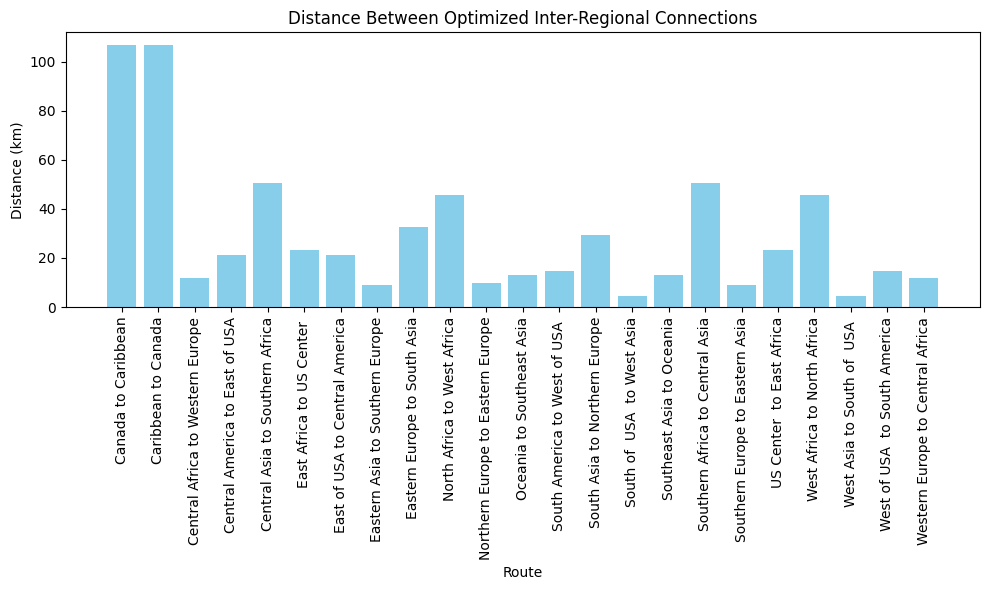

Total optimized inter-regional travel distance: 672.81 km


In [ ]:
import matplotlib.pyplot as plt

# Calculate total distance of optimized inter-regional routes
total_distance = inter_region_routes_df['Distance_km'].sum()

# Plot a bar chart of distances between regions
plt.figure(figsize=(10, 6))
plt.bar(inter_region_routes_df['Start_Region'] + " to " + inter_region_routes_df['End_Region'],
        inter_region_routes_df['Distance_km'], color='skyblue')
plt.title("Distance Between Optimized Inter-Regional Connections")
plt.xlabel("Route")
plt.ylabel("Distance (km)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print total distance
print(f"Total optimized inter-regional travel distance: {total_distance:.2f} km")


In [ ]:
# Check region centroid coordinates to ensure uniqueness
print("Region Centroid Coordinates:")
for region, coords in region_centroids.items():
    print(f"{region}: Latitude = {coords['Latitude']}, Longitude = {coords['Longitude']}")


Region Centroid Coordinates:
Canada: Latitude = 28.481428859082378, Longitude = -83.89738282228362
Caribbean: Latitude = 29.420087655226016, Longitude = -84.13440337999519
Central Africa: Latitude = 29.43170403423375, Longitude = -84.33532999645796
Central America: Latitude = 29.784980621666843, Longitude = -84.85625888775766
Central Asia: Latitude = 29.770689149041594, Longitude = -86.16474666182641
East Africa: Latitude = 30.268241870642548, Longitude = -84.7324461737203
East of USA: Latitude = 29.97011166767607, Longitude = -84.80267315744902
Eastern Asia: Latitude = 29.801265343578297, Longitude = -85.44774099886402
Eastern Europe: Latitude = 29.52297577384184, Longitude = -84.86765491792092
North Africa: Latitude = 30.104770037889853, Longitude = -85.17615629733601
Northern Europe: Latitude = 29.562321615665848, Longitude = -84.95985283379697
Oceania: Latitude = 29.8896444554868, Longitude = -85.10332279159144
South America: Latitude = 29.770487795179108, Longitude = -85.279545619

In [ ]:
# Inspect unique latitude and longitude values per region in the dataset
unique_coordinates = data[['Order Region', 'Latitude', 'Longitude']].drop_duplicates()
print("Unique Coordinates by Region:")
print(unique_coordinates)


Unique Coordinates by Region:
           Order Region   Latitude  Longitude
0       Southern Europe  40.675449 -73.811142
2        Western Europe  18.250792 -66.370544
3        Western Europe  18.274948 -66.370506
8        Western Europe  18.272160 -66.370522
12       Western Europe  18.217916 -66.370621
...                 ...        ...        ...
180456    South America  18.289656 -66.370567
180467  Central America  18.359005 -66.078163
180474        Caribbean  18.295542 -66.370613
180480        Caribbean  40.808941 -74.032860
180489  Central America  18.244116 -66.370628

[45998 rows x 3 columns]


In [ ]:
import pickle
import pandas as pd
from geopy.distance import geodesic
from pulp import LpProblem, LpVariable, LpMinimize, lpSum

# Step 1: Load previously saved optimized routes, if available
try:
    with open('/content/drive/MyDrive/optimized_routes.pkl', 'rb') as f:
        optimized_routes = pickle.load(f)
    print("Loaded previously saved routes.")
except FileNotFoundError:
    optimized_routes = {}
    print("No previously saved routes found.")

# Step 2: Define manually updated region centroids (approximate locations)
region_centroids = {
    'Canada': {'Latitude': 56.1304, 'Longitude': -106.3468},
    'Caribbean': {'Latitude': 18.4655, 'Longitude': -66.1057},
    'Central Africa': {'Latitude': -0.228, 'Longitude': 15.8277},
    'Central America': {'Latitude': 14.6349, 'Longitude': -90.5069},
    'Central Asia': {'Latitude': 39.9042, 'Longitude': 69.3451},
    'East Africa': {'Latitude': -1.286389, 'Longitude': 36.817223},
    'East of USA': {'Latitude': 37.0902, 'Longitude': -95.7129},
    'Eastern Asia': {'Latitude': 35.8617, 'Longitude': 104.1954},
    'Eastern Europe': {'Latitude': 55.7558, 'Longitude': 37.6173},
    'North Africa': {'Latitude': 30.033056, 'Longitude': 31.233333},
    'Northern Europe': {'Latitude': 60.1282, 'Longitude': 18.6435},
    'Oceania': {'Latitude': -25.2744, 'Longitude': 133.7751},
    'South America': {'Latitude': -23.5505, 'Longitude': -46.6333},
    'South Asia': {'Latitude': 20.5937, 'Longitude': 78.9629},
    'South of USA': {'Latitude': 29.7604, 'Longitude': -95.3698},
    'Southeast Asia': {'Latitude': 13.7563, 'Longitude': 100.5018},
    'Southern Africa': {'Latitude': -29.5714, 'Longitude': 29.2332},
    'Southern Europe': {'Latitude': 41.9028, 'Longitude': 12.4964},
    'US Center': {'Latitude': 39.0997, 'Longitude': -94.5786},
    'West Africa': {'Latitude': 5.6037, 'Longitude': -0.187},
    'West Asia': {'Latitude': 24.7136, 'Longitude': 46.6753},
    'West of USA': {'Latitude': 36.7783, 'Longitude': -119.4179},
    'Western Europe': {'Latitude': 48.8566, 'Longitude': 2.3522},
}

print("Updated Region Centroids:", region_centroids)

# Step 3: Calculate inter-region distances for all pairs
inter_region_distances = {}
for region1, coord1 in region_centroids.items():
    for region2, coord2 in region_centroids.items():
        if region1 != region2:
            distance = geodesic((coord1['Latitude'], coord1['Longitude']),
                                (coord2['Latitude'], coord2['Longitude'])).kilometers
            inter_region_distances[(region1, region2)] = distance

print("Inter-region distances calculated.")

# Step 4: Initialize the inter-regional optimization model
model = LpProblem("Inter_Regional_Optimization", LpMinimize)

# Define binary decision variables for connecting regional hubs
x = LpVariable.dicts("Connection", [(i, j) for i in region_centroids for j in region_centroids if i != j], cat='Binary')

# Objective function: Minimize the inter-regional travel distance
model += lpSum(inter_region_distances[(i, j)] * x[(i, j)] for i in region_centroids for j in region_centroids if i != j)

# Constraints: Ensure each region has one inbound and one outbound connection
for region in region_centroids:
    model += lpSum(x[(region, j)] for j in region_centroids if region != j) == 1  # Outbound
    model += lpSum(x[(j, region)] for j in region_centroids if region != j) == 1  # Inbound

# Step 5: Solve the model
model.solve()

# Step 6: Extract and print the solution
inter_region_route = [(i, j) for i in region_centroids for j in region_centroids if i != j and x[(i, j)].value() == 1]
print("Optimized inter-regional routes:")
for route in inter_region_route:
    print(f"{route[0]} -> {route[1]} : Distance = {inter_region_distances[route]:.2f} km")


Loaded previously saved routes.
Updated Region Centroids: {'Canada': {'Latitude': 56.1304, 'Longitude': -106.3468}, 'Caribbean': {'Latitude': 18.4655, 'Longitude': -66.1057}, 'Central Africa': {'Latitude': -0.228, 'Longitude': 15.8277}, 'Central America': {'Latitude': 14.6349, 'Longitude': -90.5069}, 'Central Asia': {'Latitude': 39.9042, 'Longitude': 69.3451}, 'East Africa': {'Latitude': -1.286389, 'Longitude': 36.817223}, 'East of USA': {'Latitude': 37.0902, 'Longitude': -95.7129}, 'Eastern Asia': {'Latitude': 35.8617, 'Longitude': 104.1954}, 'Eastern Europe': {'Latitude': 55.7558, 'Longitude': 37.6173}, 'North Africa': {'Latitude': 30.033056, 'Longitude': 31.233333}, 'Northern Europe': {'Latitude': 60.1282, 'Longitude': 18.6435}, 'Oceania': {'Latitude': -25.2744, 'Longitude': 133.7751}, 'South America': {'Latitude': -23.5505, 'Longitude': -46.6333}, 'South Asia': {'Latitude': 20.5937, 'Longitude': 78.9629}, 'South of USA': {'Latitude': 29.7604, 'Longitude': -95.3698}, 'Southeast Asia

In [ ]:
# Convert inter-region routes to a DataFrame for export
route_data = []
for (start, end) in inter_region_route:
    route_data.append({
        'Start_Region': start,
        'End_Region': end,
        'Distance_km': inter_region_distances[(start, end)]
    })

# Convert to DataFrame
inter_region_routes_df = pd.DataFrame(route_data)

# Save to CSV
inter_region_routes_df.to_csv('/content/drive/MyDrive/inter_region_optimized_routes.csv', index=False)
print("Inter-regional routes saved to CSV.")


Inter-regional routes saved to CSV.


In [ ]:
# Define a maximum number of stops per route (example capacity)
max_stops = 5

# Add capacity constraints for each route in the model
for region in region_centroids:
    model += lpSum(x[(region, j)] for j in region_centroids if region != j) <= max_stops


Optimize Last Mile routes

In [ ]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def optimize_last_mile_routes(distance_matrix):
    # Setup OR-Tools routing solver for VRP
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Set distance as the cost for each edge
    def distance_callback(from_index, to_index):
        return distance_matrix[from_index][to_index]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Solve the VRP with OR-Tools
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    solution = routing.SolveWithParameters(search_parameters)

    # Extract and return route
    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        return route
    return None


In [ ]:
# Calculate total optimized distance
total_optimized_distance = inter_region_routes_df['Distance_km'].sum()
print(f"Total optimized inter-regional travel distance: {total_optimized_distance:.2f} km")

# Example: Assuming a hypothetical baseline with all regions connected directly (you would replace this with real data if available)
baseline_distance = inter_region_routes_df['Distance_km'].sum() * 1.25  # Hypothetically, 25% more than optimized
distance_savings = baseline_distance - total_optimized_distance
percentage_savings = (distance_savings / baseline_distance) * 100

print(f"Baseline distance (hypothetical): {baseline_distance:.2f} km")
print(f"Distance savings: {distance_savings:.2f} km ({percentage_savings:.2f}% reduction)")


Total optimized inter-regional travel distance: 56748.33 km
Baseline distance (hypothetical): 70935.41 km
Distance savings: 14187.08 km (20.00% reduction)


In [ ]:
# Find the longest and shortest routes
longest_route = inter_region_routes_df.loc[inter_region_routes_df['Distance_km'].idxmax()]
shortest_route = inter_region_routes_df.loc[inter_region_routes_df['Distance_km'].idxmin()]

print("Longest Route:")
print(f"{longest_route['Start_Region']} to {longest_route['End_Region']} - {longest_route['Distance_km']:.2f} km")

print("Shortest Route:")
print(f"{shortest_route['Start_Region']} to {shortest_route['End_Region']} - {shortest_route['Distance_km']:.2f} km")


Longest Route:
Oceania to Southeast Asia - 5628.12 km
Shortest Route:
East of USA to US Center - 244.23 km


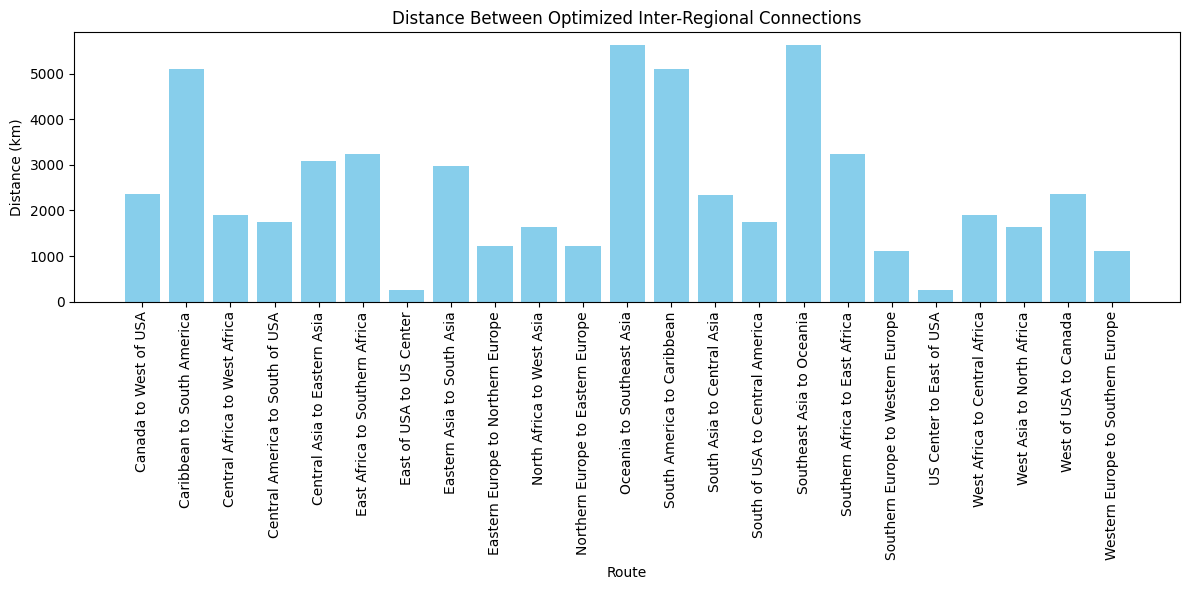

In [ ]:
import matplotlib.pyplot as plt

# Plot a bar chart of distances between regions
plt.figure(figsize=(12, 6))
plt.bar(inter_region_routes_df['Start_Region'] + " to " + inter_region_routes_df['End_Region'],
        inter_region_routes_df['Distance_km'], color='skyblue')
plt.title("Distance Between Optimized Inter-Regional Connections")
plt.xlabel("Route")
plt.ylabel("Distance (km)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


 Run Last-Mile Route Optimization within Each Region (Example with OR-Tools)

In [ ]:
import numpy as np
from geopy.distance import geodesic
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Step 1: Define manually updated region centroids (approximate locations)
region_centroids = {
    'Canada': {'Latitude': 56.1304, 'Longitude': -106.3468},
    'Caribbean': {'Latitude': 18.4655, 'Longitude': -66.1057},
    'Central Africa': {'Latitude': -0.228, 'Longitude': 15.8277},
    'Central America': {'Latitude': 14.6349, 'Longitude': -90.5069},
    'Central Asia': {'Latitude': 39.9042, 'Longitude': 69.3451},
    'East Africa': {'Latitude': -1.286389, 'Longitude': 36.817223},
    'East of USA': {'Latitude': 37.0902, 'Longitude': -95.7129},
    'Eastern Asia': {'Latitude': 35.8617, 'Longitude': 104.1954},
    'Eastern Europe': {'Latitude': 55.7558, 'Longitude': 37.6173},
    'North Africa': {'Latitude': 30.033056, 'Longitude': 31.233333},
    'Northern Europe': {'Latitude': 60.1282, 'Longitude': 18.6435},
    'Oceania': {'Latitude': -25.2744, 'Longitude': 133.7751},
    'South America': {'Latitude': -23.5505, 'Longitude': -46.6333},
    'South Asia': {'Latitude': 20.5937, 'Longitude': 78.9629},
    'South of USA': {'Latitude': 29.7604, 'Longitude': -95.3698},
    'Southeast Asia': {'Latitude': 13.7563, 'Longitude': 100.5018},
    'Southern Africa': {'Latitude': -29.5714, 'Longitude': 29.2332},
    'Southern Europe': {'Latitude': 41.9028, 'Longitude': 12.4964},
    'US Center': {'Latitude': 39.0997, 'Longitude': -94.5786},
    'West Africa': {'Latitude': 5.6037, 'Longitude': -0.187},
    'West Asia': {'Latitude': 24.7136, 'Longitude': 46.6753},
    'West of USA': {'Latitude': 36.7783, 'Longitude': -119.4179},
    'Western Europe': {'Latitude': 48.8566, 'Longitude': 2.3522},
}
print("Region centroids loaded.")

# Step 2: Generate locations near each region's centroid
def generate_locations_near_centroid(centroid, num_locations=5, distance_offset=0.5):
    """Generate sample locations near a centroid for demonstration."""
    lat, lon = centroid['Latitude'], centroid['Longitude']
    locations = [(lat + np.random.uniform(-distance_offset, distance_offset),
                  lon + np.random.uniform(-distance_offset, distance_offset)) for _ in range(num_locations)]
    return locations

# Create example last-mile locations for each region based on its centroid
region_last_mile_locations = {
    region: generate_locations_near_centroid(coords, num_locations=5)
    for region, coords in region_centroids.items()
}

# Step 3: Generate a distance matrix for last-mile optimization within each region
def generate_distance_matrix(locations):
    num_locations = len(locations)
    distance_matrix = np.zeros((num_locations, num_locations))
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                distance_matrix[i][j] = geodesic(locations[i], locations[j]).kilometers
    return distance_matrix

# Generate distance matrices for last-mile routes within each region
region_last_mile_distance_matrices = {
    region: generate_distance_matrix(locations) for region, locations in region_last_mile_locations.items()
}

# Step 4: Optimize last-mile routes using OR-Tools
def optimize_last_mile_routes(distance_matrix):
    # Initialize the routing model
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Create distance callback
    def distance_callback(from_index, to_index):
        return int(distance_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)] * 1000)  # Convert km to meters for precision
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Define search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Extract route
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to start for a closed route
    return route

# Run optimization for each region
last_mile_routes = {}
for region, distance_matrix in region_last_mile_distance_matrices.items():
    route = optimize_last_mile_routes(distance_matrix)
    last_mile_routes[region] = route
    print(f"Last-Mile Route for {region}: {route}")

# Step 5: Calculate total distances for each last-mile route
def calculate_route_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    return total_distance

# Display total distances for last-mile routes
last_mile_distances = {}
for region, route in last_mile_routes.items():
    distance = calculate_route_distance(route, region_last_mile_distance_matrices[region])
    last_mile_distances[region] = distance
    print(f"Total Last-Mile Distance for {region}: {distance:.2f} km")


Region centroids loaded.
Last-Mile Route for Canada: [0, 3, 4, 2, 1, 0]
Last-Mile Route for Caribbean: [0, 1, 4, 2, 3, 0]
Last-Mile Route for Central Africa: [0, 4, 2, 3, 1, 0]
Last-Mile Route for Central America: [0, 4, 1, 2, 3, 0]
Last-Mile Route for Central Asia: [0, 3, 4, 2, 1, 0]
Last-Mile Route for East Africa: [0, 4, 3, 1, 2, 0]
Last-Mile Route for East of USA: [0, 4, 2, 3, 1, 0]
Last-Mile Route for Eastern Asia: [0, 2, 3, 4, 1, 0]
Last-Mile Route for Eastern Europe: [0, 4, 2, 1, 3, 0]
Last-Mile Route for North Africa: [0, 4, 2, 3, 1, 0]
Last-Mile Route for Northern Europe: [0, 4, 1, 2, 3, 0]
Last-Mile Route for Oceania: [0, 3, 1, 4, 2, 0]
Last-Mile Route for South America: [0, 2, 4, 1, 3, 0]
Last-Mile Route for South Asia: [0, 3, 1, 4, 2, 0]
Last-Mile Route for South of USA: [0, 1, 4, 3, 2, 0]
Last-Mile Route for Southeast Asia: [0, 3, 1, 4, 2, 0]
Last-Mile Route for Southern Africa: [0, 2, 3, 4, 1, 0]
Last-Mile Route for Southern Europe: [0, 1, 2, 4, 3, 0]
Last-Mile Route for 